In [1]:
import os
import time
import cv2
import numpy as np
from skimage import segmentation
import matplotlib.pyplot as plt
from osgeo import gdal, ogr
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from IPython import display

In [2]:
class MyNet(nn.Module):
    def __init__(self, inp_dim, mod_dim1, mod_dim2):
        super(MyNet, self).__init__()

        self.seq = nn.Sequential(
            nn.Conv2d(inp_dim, mod_dim1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(mod_dim1),
            nn.ReLU(inplace=True),

            nn.Conv2d(mod_dim1, mod_dim2, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(mod_dim2),
            nn.ReLU(inplace=True),

            nn.Conv2d(mod_dim2, mod_dim1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(mod_dim1),
            nn.ReLU(inplace=True),

            nn.Conv2d(mod_dim1, mod_dim2, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(mod_dim2),
        )

    def forward(self, x):
        return self.seq(x)

In [3]:
def segmentation_ML(image, scale, sigma, min_size):
    seg_map = segmentation.felzenszwalb(image.transpose((0, 1, 2)), scale=1, sigma=sigma, min_size=min_size)
    # seg_map = segmentation.slic(image.transpose((1, 2, 0)), n_segments=100000, compactness=100)
    # plt.imshow(seg_map)
    seg_map = seg_map.flatten()
    seg_lab = [np.where(seg_map == u_label)[0]
               for u_label in np.unique(seg_map)]
    return seg_lab

In [4]:
def train_init(image, lr, momentum, dim):
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

    tensor = image.transpose((2, 0, 1))
#     tensor = image
    tensor = tensor.astype(np.float32) / 255.0
    tensor = tensor[np.newaxis, :, :, :]
#     tensor = tensor[np.newaxis]
    tensor = torch.from_numpy(tensor).to(device)

    model = MyNet(inp_dim=dim, mod_dim1=mod_dim1, mod_dim2=mod_dim2).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-1, momentum=0.0)

    # image_flatten = image.reshape((-1, 7))
    # color_avg = np.random.randint(255, size=(args.max_label_num, 7))
    # show = image[0]
    return tensor, model, criterion, optimizer, device, scheduler

In [5]:
def train(epoch, tensor, seg_lab, model, optimizer, criterion, min_label_num, scheduler):
    start_time1 = time.time()
    model.train()
    plt.figure(figsize=(15, 15))
    for batch_idx in range(train_epoch):
        '''forward'''
        optimizer.zero_grad()
        output = model(tensor)[0]
        output = output.permute(1, 2, 0).view(-1, mod_dim2)
#         print(output.shape)
        target = torch.argmax(output, 1)
        im_target = target.data.cpu().numpy()

        '''refine'''
        for inds in seg_lab:
            u_labels, hist = np.unique(im_target[inds], return_counts=True)
            im_target[inds] = u_labels[np.argmax(hist)]
    #     print(im_target)
        '''backward'''
        target = torch.from_numpy(im_target)
        target = target.to(device)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()

        '''show image'''
        un_label, lab_inverse = np.unique(im_target, return_inverse=True,)
    #     print(un_label)
        if un_label.shape[0] < max_label_num:  # update show
    #         img_flatten = image_flatten.copy()
    #         if len(color_avg) != un_label.shape[0]:
    #             color_avg = [np.mean(img_flatten[im_target == label], axis=0, dtype=np.int) for label in un_label]
    # #             print([im_target == label for label in un_label])
    #         for lab_id, color in enumerate(color_avg):
    #             img_flatten[lab_inverse == lab_id] = color
    #         show = img_flatten.reshape(image.shape)
    #     cv2.imshow("seg_pt", show)
    #     cv2.waitKey(1)
            show = im_target.reshape(image[:, :, 0].shape)


#         print('Loss:', batch_idx, loss.item())
        plt.suptitle('Epoch: ' + str(batch_idx) + ' Loss: ' + str(loss.item()) + ' Class_num: ' + str(len(np.unique(show))),fontsize=30)
        plt.imshow(show)
        display.display(plt.gcf())
        display.clear_output(wait=True)
#         time.sleep(1)
        if len(un_label) <= min_label_num:
            break
    return show

# print(img_flatten[0], img_flatten[False], img_flatten[True], color_avg)

In [6]:
def save_png(path, show):
#     time0 = time.time() - start_time0
#     time1 = time.time() - start_time1
#     print('PyTorchInit: %.2f\nTimeUsed: %.2f' % (time0, time1))
#     if os.path.exists('D:\\yyx\\GEE\\data\\changbai\\CB_test1.png'):
#         os.remove('D:\\yyx\\GEE\\data\\changbai\\CB_test1.png')
#     cv2.imwrite('D:\\yyx\\GEE\\data\\changbai\\CB_test1.png', show)
    cv2.imwrite(path, show)

In [7]:
def save_tif(CB_tif, path, show):
    if os.path.exists('D:\\yyx\\GEE\\data\\changbai\\CB_test1.tif'):
        os.remove('D:\\yyx\\GEE\\data\\changbai\\CB_test1.tif')
    width = CB_tif.RasterXSize
    height = CB_tif.RasterYSize
    driver = gdal.GetDriverByName("GTiff")
    tods = driver.Create('D:\\yyx\\GEE\\data\\changbai\\CB_test1.tif', width, height, 3, options=["INTERLEAVE=PIXEL"])
#     tods = driver.Create(path, width, height, 3, options=["INTERLEAVE=PIXEL"])
    tra = CB_tif.GetGeoTransform()
    pro = CB_tif.GetProjectionRef()
    tods.SetGeoTransform(tra)
    tods.SetProjection(pro)
    tods.GetRasterBand(1).WriteArray(show)
    tods = None

In [8]:
input_image_path = 'D:\\Competition\\train\\image\\5.tif'
train_epoch = 256
mod_dim1 = 64  #
mod_dim2 = 32
gpu_id = 0

min_label_num = 8  # if the label number small than it, break loop
max_label_num = 256  # if the label number small than it, start to show result image.

In [9]:
start_time0 = time.time()

# CB_tif = gdal.Open(args.input_image_path)
# image = []
torch.cuda.manual_seed_all(1943)
np.random.seed(1943)
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)  # choose GPU:0
image = cv2.imread(input_image_path)
# for band in range(1, CB_tif.RasterCount):
#     image.append(CB_tif.GetRasterBand(band).ReadAsArray())
# image = np.array(image)

In [10]:
image.shape

(256, 256, 3)

In [11]:
# path = 'D:\\yyx\\GEE\\data\\changbai\\tiaocan\\'
# for sigma in np.arange(0.1, 1, 0.1):
#     seg_lab = segmentation_ML(1, sigma, 32)
#     for lr in np.arange(0.01, 0.1, 0.01):
#         for min_label_num in np.arange(6, 13):
#             tensor, model, criterion, optimizer, device = train_init(image, lr, 0.9)
#             show = train(args.train_epoch, tensor, seg_lab, model, optimizer, criterion, min_label_num)
# #             path_png = path + str(lr) + '_' + str(sigma) + '_' + str(min_label_num) + '.png'
# #             save_png(path_png, show)
#             path_tif = path + str(lr) + '_' + str(sigma) + '_' + str(min_label_num) + '.tif'
#             save_tif(CB_tif, path_tif, show)
#             print(lr, sigma, min_label_num)

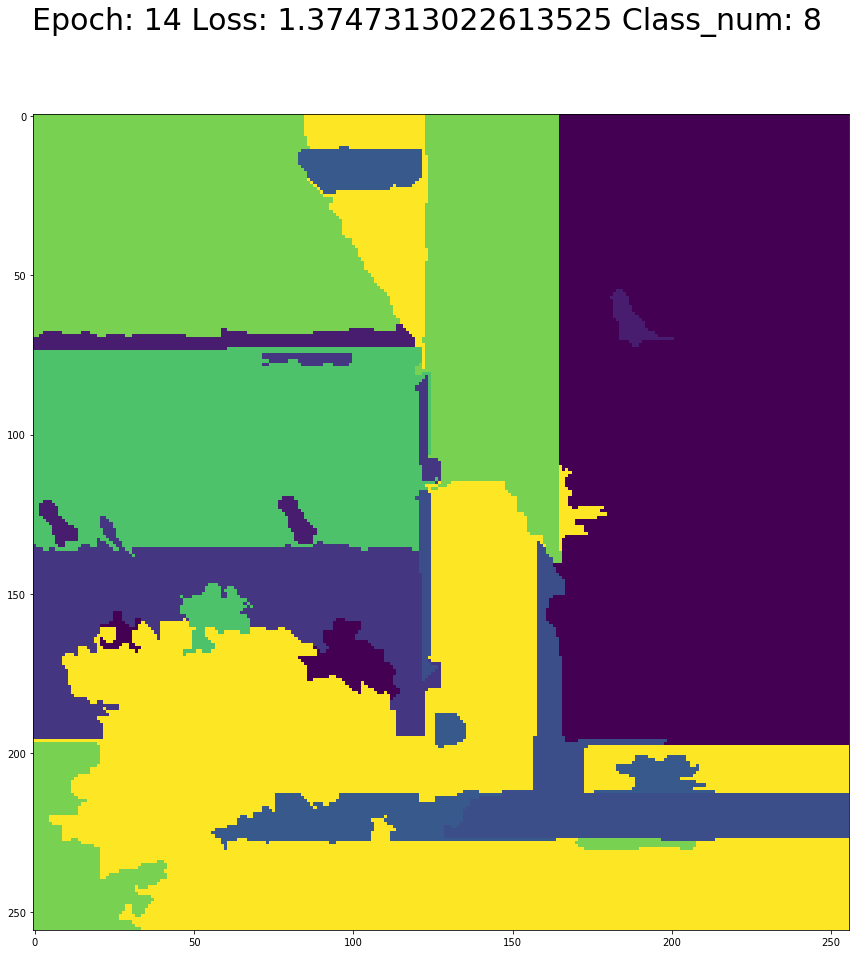

In [13]:
sigma = 0.5
lr = 0.03
min_label_num = 8
min_size = 64
scale = 32
dim_num = 3

seg_lab = segmentation_ML(image, scale, sigma, min_size)
tensor, model, criterion, optimizer, device, scheduler = train_init(image, lr, 0.9, dim_num)
# print(tensor.shape)
show = train(train_epoch, tensor, seg_lab, model, optimizer, criterion, min_label_num, scheduler)
# save_tif(CB_tif, 1, show)
# tensor.shape

In [23]:
a = np.array(['12345', 'abc'])
a + '1'

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U5') dtype('<U5') dtype('<U5')

In [ ]:
seg_lab